# Python求解ODE
可以参考：  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
我们先做下面这个题：

> 设位于坐标原点的甲舰向位于 x 轴上点 A（1,0）处的乙舰发射导弹，导弹头始终对准乙舰。如果乙舰以最大速度 1 沿平行于 y 轴的直线行驶，导弹的速度为 5，求导弹的运行的曲线方程，以及乙舰行驶多远时，导弹将击中它？

In [1]:
# 我们用scypi的solve_ivp，ivp就是initial value problem
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
print('---')


c:\Users\zheng\anaconda3\envs\experiment\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\zheng\anaconda3\envs\experiment\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\zheng\anaconda3\envs\experiment\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


---


## 这里先定义我们要解的微分方程
$$
\begin{cases}
x'=\frac{5(1-x)}{\sqrt{(1-x)^2+(t-y)^2}}\\
y'=\frac{5(t-y)}{\sqrt{(1-x)^2+(t-y)^2}}  \\
x(0)=0,y(0)=0
\end{cases}
$$

In [3]:
# 这里先定义我们要解的微分方程
# 输入y是一个array like，里面没包含了n个求解的对象
# 返回值也是一个array like，就是n个微分


def eq2(t, y):
    dy0 = 5 * (1 - y[0]) / np.sqrt((1 - y[0]) ** 2 + (t - y[1]) ** 2)
    dy1 = 5 * (t - y[1]) / np.sqrt((1 - y[0]) ** 2 + (t - y[1]) ** 2)
    return np.array([dy0, dy1])


# 这里定义我们的求解范围t=0~0.3
t0 = 0
tf = 0.3

(2, 74)
[0.00000000e+00 1.00000000e-04 1.10000000e-03 6.10000000e-03
 1.11000000e-02 1.61000000e-02 2.11000000e-02 2.61000000e-02
 3.11000000e-02 3.61000000e-02 4.11000000e-02 4.61000000e-02
 5.11000000e-02 5.61000000e-02 6.11000000e-02 6.61000000e-02
 7.11000000e-02 7.61000000e-02 8.11000000e-02 8.61000000e-02
 9.11000000e-02 9.61000000e-02 1.01100000e-01 1.06100000e-01
 1.11100000e-01 1.16100000e-01 1.21100000e-01 1.26100000e-01
 1.31100000e-01 1.36100000e-01 1.41100000e-01 1.46100000e-01
 1.51100000e-01 1.56100000e-01 1.61100000e-01 1.66100000e-01
 1.71100000e-01 1.76100000e-01 1.81100000e-01 1.86100000e-01
 1.91100000e-01 1.96100000e-01 2.01100000e-01 2.06100000e-01
 2.08711495e-01 2.11201546e-01 2.12644824e-01 2.14088101e-01
 2.15915922e-01 2.18240490e-01 2.20272815e-01 2.22305139e-01
 2.24758501e-01 2.27630113e-01 2.30873045e-01 2.34419240e-01
 2.38236667e-01 2.42421016e-01 2.46933627e-01 2.51613376e-01
 2.54744627e-01 2.57160758e-01 2.59576888e-01 2.62446602e-01
 2.65779819e-01 

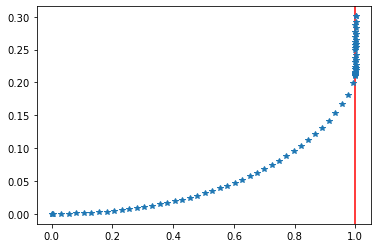

In [5]:
# 这里就可以求解了，我门送进去方程，求解方位，初值，以及最大的step
# 因为solve_ivp是变步长求解的，他自动求解，会在不影响最终精度的时候选在比价大的step，
# 我们可以限制一下画图简单些
sol = solve_ivp(eq2, [t0, tf], [0, 0], max_step=0.005)
#
y = sol.y
print(y.shape)
plt.axvline(x=1, ymin=0, ymax=1, color='r')
plt.plot(y[0], y[1], '*')  # 导弹的运动曲线
plt.show()

## 事件
时间非常重要，因为你列微分方程的时候不知道什么时候，需要停止积分，
例如刚刚那个pursuit curve，导弹打船，当导弹打到船的时候就可以停止了。
或者再求解的过程中有很多重要的时间点，例如往天上跑一个球，你希望在最高点的时候记录下来他的最高点。
事件就是这个功能。你写一个函数他是t和y的函数，当他返回值=0的时候就代表事件发生了，求解器会自动地，
停止求解，或者记录下这一点的t。

下面我们做个例子,注意事件这个函数应该是连续函数，并且会过零，如果只是无限接近与0，那么是不行的。
在上面这个例子中，我们让导弹打到船就停止，并且，如果立传的距离小于0.5则记录下当前点的位置。
我们上面那个打船的例子，导弹命中船作为事件的话，如果你输出道传的距离是永远不会到0的，
所以，应该是距离小于某个值。

In [7]:

# 命中目标


def hitEvent(t, y):
    # hit when with in this distance
    hitRadius = 0.005
    return np.sqrt((1 - y[0]) ** 2 + (t - y[1]) ** 2)-0.005

# 进入0.5范围


def inrangeEvent(t, y):
    # hit when with in this distance
    hitRadius = 0.5
    return np.sqrt((1 - y[0]) ** 2 + (t - y[1]) ** 2)-0.5



[array([0.20721086]), array([0.10125665])]
0.10125665454182232
0.20721086196660096


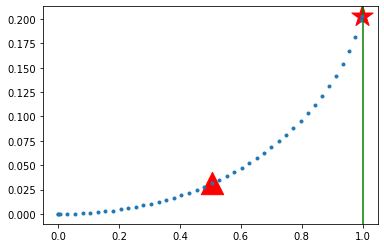

In [10]:
# 表示发生事件后停止积分
hitEvent.terminal = True
hitEvent.direction=-1
# 代表仅仅从整变为负的时候触发事件，默认两端都触发事件
#inrangeEvent.direction = -1
tf = 1
sol = solve_ivp(eq2, [t0, tf], [0, 0], events=[
                hitEvent, inrangeEvent], max_step=0.005)
# t_evetn表示事件发生的时间
print(sol.t_events)
plt.axvline(x=1, ymin=0, ymax=1, color='g')
plt.plot(sol.y[0], sol.y[1], '.')  # 导弹的运动曲线
# 命中点
# 这个sol.y_events是发生事件点的y的值，是一个list，每一项对应一个事件，
# 这个list每个元素是一个2维数组，行是第几次事件，一行就是一个y，列是y的每个维度
plt.scatter(sol.y_events[0][0, 0], sol.y_events[0]
            [0, 1], marker='*', color='r', s=500)
# 进入范围点
plt.scatter(sol.y_events[1][0, 0], sol.y_events[1]
            [0, 1], marker='^', color='r', s=500)

print(sol.t_events[1][0])
print(sol.t_events[0][0])
plt.show()
